Enter 1 for feature extraction if not done yet, 2 for testing: 2
[STATUS] features shape: (1320, 532)
[STATUS] labels shape: (1320,)
[STATUS] training started...
[STATUS] splitted train and test data...
Train data  : (1188, 532)
Test data   : (132, 532)
Train labels: (1188,)
Test labels : (132,)
LR: 1.000000 (0.000000)
LDA: 0.996617 (0.007762)
KNN: 1.000000 (0.000000)
CART: 0.994951 (0.005578)
RF: 1.000000 (0.000000)
NB: 0.978963 (0.010119)
SVM: 0.896482 (0.045383)


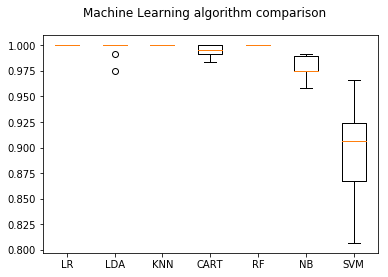

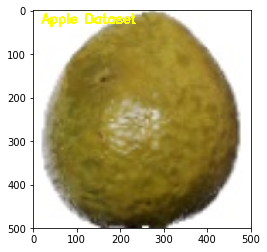

In [6]:
#-----------------------------------
# TRAINING OUR MODEL
#-----------------------------------

# import the necessary packages
import h5py
import numpy as np
import os
import glob
import mahotas
import cv2
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler



# fixed-sizes for image
fixed_size = tuple((500, 500))

# path to training data
train_path = "C:/Users/mcs/Desktop/image-classification-main/dataset/train"

# no.of.trees for Random Forests
num_trees = 120

# bins for histogram
bins = 8

# train_test_split size
test_size = 0.10

# seed for reproducing same results
seed = 9

# variables to hold the results and names
results = []
names = []
scoring = "accuracy"

# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()


def featureExtraction():
	# get the training labels
	train_labels = os.listdir(train_path)

	# sort the training labels
	train_labels.sort()
	print(train_labels)

	# empty lists to hold feature vectors and labels
	global_features = []
	labels = []

	i, j = 0, 0
	k = 0

	# num of images per class
	images_per_class = 120  

	#%%time
	# loop over the training data sub-folders
	for training_name in train_labels:
	    # join the training data path and each species training folder
	    dir = os.path.join(train_path, training_name)
	    #print(dir)
	    # get the current training label
	    current_label = training_name

	    k = 1
	    # loop over the images in each sub-folder
	    for x in range(1,images_per_class+1):
	        # get the image file name
	        
	        print(dir)
	        file = dir + "/" + str(x) + ".jpg"
	        print(file)
	        # read the image and resize it to a fixed-size
	        image = cv2.imread(file)
	        #image = cv2.resize(image, fixed_size)

	        ####################################
	        # Global Feature extraction
	        ####################################
	        fv_hu_moments = fd_hu_moments(image)
	        fv_haralick   = fd_haralick(image)
	        fv_histogram  = fd_histogram(image)

	        ###################################
	        # Concatenate global features
	        ###################################
	        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

	        # update the list of labels and feature vectors
	        labels.append(current_label)
	        global_features.append(global_feature)

	        i += 1
	        k += 1
	    cv2.imshow("image",image)
	    print ("[STATUS] processed folder: {}".format(current_label))
	    j += 1

	print("[STATUS] completed Global Feature Extraction...")

	#%%time
	# get the overall feature vector size
	print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

	# get the overall training label size
	print("[STATUS] training Labels {}".format(np.array(labels).shape))

	# encode the target labels
	targetNames = np.unique(labels)
	le = LabelEncoder()
	target = le.fit_transform(labels)
	print("[STATUS] training labels encoded...")

	# normalize the feature vector in the range (0-1)
	scaler = MinMaxScaler(feature_range=(0, 1))
	rescaled_features = scaler.fit_transform(global_features)
	print("[STATUS] feature vector normalized...")

	print("[STATUS] target labels: {}".format(target))
	print("[STATUS] target labels shape: {}".format(target.shape))

	# save the feature vector using HDF5
	h5f_data = h5py.File('data.h5', 'w')
	h5f_data.create_dataset(name='dataset_1', data=np.array(rescaled_features), chunks=True, compression='gzip')

	h5f_label = h5py.File('labels.h5', 'w')
	h5f_label.create_dataset(name='dataset_1', data=np.array(target))

	h5f_data.close()
	h5f_label.close()

	print("[STATUS] end of training..")
#---------------End feature extraction functionn---------------	
models = []
def test_train():
	# create all the machine learning models
	models.append(('LR', LogisticRegression(random_state=9)))
	models.append(('LDA', LinearDiscriminantAnalysis()))
	models.append(('KNN', KNeighborsClassifier()))
	models.append(('CART', DecisionTreeClassifier(random_state=9)))
	models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=9)))
	models.append(('NB', GaussianNB()))
	models.append(('SVM', SVC(random_state=9)))


	# import the feature vector and trained labels
	#h5f_data  = h5py.File('C:/Users/Sazon/Desktop/image-classification/after editing/data.h5', 'r')
	#h5f_label = h5py.File('C:/Users/Sazon/Desktop/image-classification/after editing/labels.h5', 'r')
	h5f_data  = h5py.File('data.h5', 'r')
	h5f_label = h5py.File('labels.h5', 'r')

	global_features_string = h5f_data['dataset_1']
	global_labels_string = h5f_label['dataset_1']

	global_features = np.array(global_features_string)
	global_labels = np.array(global_labels_string)

	h5f_data.close()
	h5f_label.close()

	# verify the shape of the feature vector and labels
	print("[STATUS] features shape: {}".format(global_features.shape))
	print("[STATUS] labels shape: {}".format(global_labels.shape))
	print("[STATUS] training started...")

	# split the training and testing data
	(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
	                                                                                          np.array(global_labels),
	                                                                                          test_size=test_size,
	                                                                                          random_state=seed)

	print("[STATUS] splitted train and test data...")
	print("Train data  : {}".format(trainDataGlobal.shape))
	print("Test data   : {}".format(testDataGlobal.shape))
	print("Train labels: {}".format(trainLabelsGlobal.shape))
	print("Test labels : {}".format(testLabelsGlobal.shape))

	# filter all the warnings
	warnings.filterwarnings('ignore')

	# 10-fold cross validation
	for name, model in models:
	    kfold = KFold(n_splits=10, random_state=7)
	    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
	    results.append(cv_results)
	    names.append(name)
	    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	    print(msg)

	# boxplot algorithm comparison
	fig = pyplot.figure()
	fig.suptitle('Machine Learning algorithm comparison')
	ax = fig.add_subplot(111)
	pyplot.boxplot(results)
	ax.set_xticklabels(names)
	pyplot.show()



	# to visualize results
	import matplotlib.pyplot as plt

	# create the model - Random Forests
	clf  = RandomForestClassifier(n_estimators=100, random_state=9)

	# fit the training data to the model
	clf.fit(trainDataGlobal, trainLabelsGlobal)

	# path to test data
	train_path = "C:/Users/mcs/Desktop/image-classification-main/dataset/train"
	test_path = "C:/Users/mcs/Desktop/image-classification-main/dataset/test"
	#train_labels = os.listdir(train_path)
	# loop through the test images
	for file in glob.glob(test_path + "/*.jpg"):
	    # read the image
	    image = cv2.imread(file)
	    
	    
	    train_labels = os.listdir(train_path)
	    
	    # resize the image
	    image = cv2.resize(image, fixed_size)
	    ####################################
	    # Global Feature extraction
	    ####################################
	    fv_hu_moments = fd_hu_moments(image)
	    fv_haralick   = fd_haralick(image)
	    fv_histogram  = fd_histogram(image)

	    ###################################
	    # Concatenate global features
	    ###################################
	    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

	    # predict label of test image
	    prediction = clf.predict(global_feature.reshape(1,-1))[0]
	    
	    
	    # show predicted label on image
	    cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

	    # display the output image
	    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
	plt.show()
#----------------Training and testing part close here

#------------Call the function------------------------
a = int(input("Enter 1 for feature extraction if not done yet, 2 for testing: "))
if a==1:
    featureExtraction()
else:
    test_train()